In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import pandas as pd 

In [2]:
def gaussian_k(x0,y0,sigma, width, height):
        """ Make a square gaussian kernel centered at (x0, y0) with sigma as SD.
        """
        x = np.arange(0, width, 1, float) ## (width,)
        y = np.arange(0, height, 1, float)[:, np.newaxis] ## (height,1)
        return np.exp(-((x-x0)**2 + (y-y0)**2) / (2*sigma**2))

def generate_hm(height, width ,points,sigma):
        """ Generate a full Heap Map for every points in an array
        Args:
            height    : The height of Heat Map (the height of target output)
            width     : The width  of Heat Map (the width of target output)
        """
        hm = np.zeros((height, width, len(points)), dtype = np.float32)
        for i in range(len(points)):
            hm[:,:,i] = gaussian_k(points[i][0],
                                    points[i][1],
                                    sigma, width, height)
        return hm
    
def get_y_as_heatmap(keypoints,height,width, sigma): 
    return np.array([generate_hm(height, width, image_keypoints / 5., sigma) for image_keypoints in keypoints], dtype=np.float32)

In [3]:
def load_keypoints(image_number):
    return np.load(f'./keypoints/00{image_number}_gt_keypoints2d.npy')

def load(width=128,height=96,sigma=3, image_number=10):
    """
    load test/train data
    cols : a list containing landmark label names.
           If this is specified, only the subset of the landmark labels are 
           extracted. for example, cols could be:
           
          [left_eye_center_x, left_eye_center_y]
            
    return: 
    heatmaps:  2-d numpy array (Nsample, Nlandmarks*2) 
    """
    from sklearn.utils import shuffle
    
    keypoints = load_keypoints(image_number)
    heatmaps = get_y_as_heatmap(keypoints, height, width, sigma)
    return heatmaps

def load_many(width=128, height=96, sigma=4, image_folders=['10']):        
    return np.vstack([load(width, height, sigma, no) for no in image_folders])

In [4]:
heatmaps_train = load_many(image_folders=['10', '11', '18', '24', '30', '37'])
heatmaps_train.shape

(1522, 96, 128, 9)

In [5]:
heatmaps_test = load_many(image_folders=['50'])
n_test = heatmaps_test.shape[0]
heatmaps_test.shape

(320, 96, 128, 9)

In [6]:
from pathlib import Path
root = Path().cwd()/"images"

images = tf.keras.preprocessing.image_dataset_from_directory(
    root,
    image_size=(96, 128),
    shuffle=False
)

images, _ = zip(*images.unbatch())
images = np.array(images)

images.shape

Found 1842 files belonging to 7 classes.


(1842, 96, 128, 3)

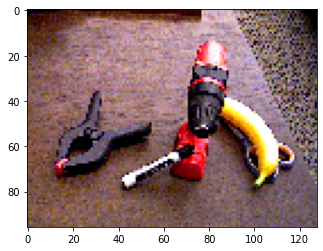

In [7]:
images /= 255.
plt.imshow(images[0])

In [8]:
images_train, images_test = images[:-n_test], images[-n_test:]

images_train.shape, images_test.shape

((1522, 96, 128, 3), (320, 96, 128, 3))

In [9]:
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(images, heatmaps, test_size=0.2, random_state=42)

## Visualize image together with heatmap

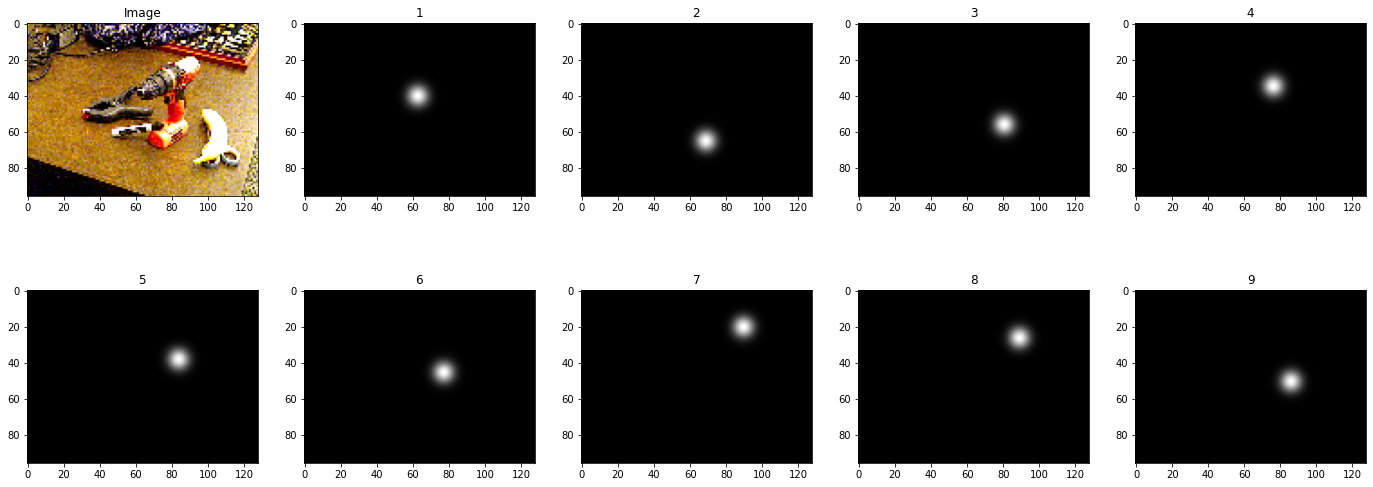

In [11]:
idx = 100

def plot_image_with_keypoints_heatmap(image, heatmap):
    keypoint_number = heatmap.shape[2]+1

    fig = plt.figure(figsize=(24,9))
    ax = fig.add_subplot(2, keypoint_number//2, 1)
    ax.imshow(image)
    ax.set_title("Image")
    for i in range(heatmaps_train.shape[-1]):
        ax = fig.add_subplot(2, keypoint_number//2, i+2)
        ax.imshow(heatmap[:,:,i],cmap="gray")
        ax.set_title(str(i+1))
    plt.show()

plot_image_with_keypoints_heatmap(images_train[idx], heatmaps_train[idx])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


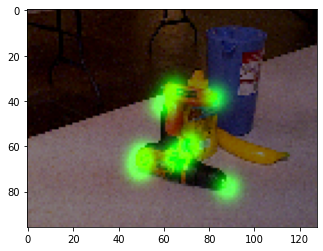

In [12]:
idx = 1000

def plot_image_with_heatmaps(image, heatmap):
    image = image.copy()
    image *= 0.5

    for i in range(9):
        image[:, :, 1] = image[:, :, 1] + heatmap[:,:,i]

    plt.imshow(image)
    
plot_image_with_heatmaps(images_train[idx], heatmaps_train[idx])

# Model

In [13]:
from stacked_hourglass import create_stacked_hourglass_model

N_KEYPOINTS = 9
N_HOURGLASSES = 2
START_FILTERS = 64
MAX_FILTERS = 256

In [14]:
img_input = tf.keras.Input(shape=(96, 128, 3))
stacked_hourglass_model = create_stacked_hourglass_model(img_input, 
                                                         N_KEYPOINTS, 
                                                         N_HOURGLASSES, 
                                                         START_FILTERS, 
                                                         MAX_FILTERS, 
                                                         mode='residual')

stacked_hourglass_model.compile(optimizer=tf.keras.optimizers.Adam(), 
                                loss=tf.keras.losses.mean_squared_error)

stacked_hourglass_model.load_weights('./model_checkpoints/stacked_hourglass/')
print('train')
stacked_hourglass_model.evaluate(images_train, heatmaps_train, verbose=2)
print('test')
stacked_hourglass_model.evaluate(images_test, heatmaps_test, verbose=2)
None

train
48/48 - 13s - loss: 0.0033 - output_0_loss: 0.0017 - output_1_loss: 0.0017 - 13s/epoch - 281ms/step
test
10/10 - 2s - loss: 0.0074 - output_0_loss: 0.0038 - output_1_loss: 0.0036 - 2s/epoch - 226ms/step


# Training

In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='./model_checkpoints/stacked_hourglass/', save_weights_only=True, save_best_only=True, verbose=1)

sh_model_history = stacked_hourglass_model.fit(images_train, heatmaps_train, batch_size=16, epochs=20, validation_data=(images_test, heatmaps_test), callbacks=[cp_callback])

Epoch 1/20
96/96 [==============================] - 36s 330ms/step - loss: 0.1076 - output_0_loss: 0.0493 - output_1_loss: 0.0583 - val_loss: 0.0365 - val_output_0_loss: 0.0200 - val_output_1_loss: 0.0165

Epoch 00001: val_loss improved from inf to 0.03646, saving model to ./model_checkpoints/stacked_hourglass\
Epoch 2/20
96/96 [==============================] - 30s 317ms/step - loss: 0.0141 - output_0_loss: 0.0072 - output_1_loss: 0.0069 - val_loss: 0.0116 - val_output_0_loss: 0.0057 - val_output_1_loss: 0.0059

Epoch 00002: val_loss improved from 0.03646 to 0.01162, saving model to ./model_checkpoints/stacked_hourglass\
Epoch 3/20
96/96 [==============================] - 30s 315ms/step - loss: 0.0095 - output_0_loss: 0.0047 - output_1_loss: 0.0048 - val_loss: 0.0088 - val_output_0_loss: 0.0043 - val_output_1_loss: 0.0046

Epoch 00003: val_loss improved from 0.01162 to 0.00884, saving model to ./model_checkpoints/stacked_hourglass\
Epoch 4/20
96/96 [==============================] - 3

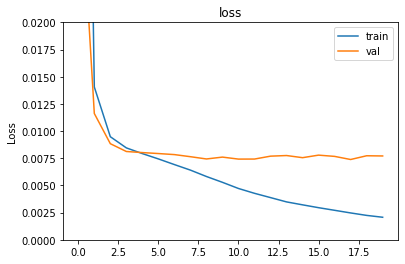

In [ ]:
def plot_stats(history, output='loss', save_path=None, ymax=0.02):
    plt.plot(history.history[output])
    plt.plot(history.history[f'val_{output}'])
    plt.title('Loss')
    plt.ylabel('Loss')
    ax = plt.gca()
    ax.set_ylim([0.0, ymax])
    plt.legend(['train', 'val'])
    plt.title(output)
    
    if save_path is not None:
        plt.savefig(save_path)
        
    plt.show()
    
plot_stats(sh_model_history, save_path='./plots/stacked_hourglass_training/loss.jpg')

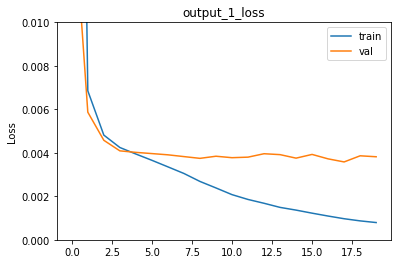

In [ ]:
plot_stats(sh_model_history, 'output_1_loss', save_path='./plots/stacked_hourglass_training/output_1_loss.jpg', ymax=0.01)

## Simple model

In [ ]:
# simpler fnc-like network
img_input = tf.keras.Input(shape=(96, 128, 3))

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(img_input)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
block1 = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(block1)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

x = tf.keras.layers.Conv2D(160, (24, 32), activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(160, (1, 1), activation='relu', padding='same')(x)

x = tf.keras.layers.Conv2DTranspose(9, kernel_size=(2, 2), strides=(2, 2), use_bias=False)(x)
output = tf.keras.layers.Conv2DTranspose(9, kernel_size=(2, 2), strides=(2, 2), use_bias=False)(x)

simple_model = tf.keras.Model(img_input, [output])

simple_model.compile(optimizer=tf.keras.optimizers.Adam(), 
                                loss=tf.keras.losses.mean_squared_error)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='./model_checkpoints/simple/', save_weights_only=True, save_best_only=True, verbose=1)

simple_model_history = simple_model.fit(images_train, heatmaps_train, batch_size=8, epochs=10, validation_data=(images_test, heatmaps_test), callbacks=[cp_callback])

# simple_model.load_weights('./model_checkpoints/simple/')
# print('train')
# simple_model.evaluate(images_train, heatmaps_train, verbose=2)
# print('test')
# simple_model.evaluate(images_test, heatmaps_test, verbose=2)
# None

Epoch 1/10
191/191 [==============================] - 15s 65ms/step - loss: 0.0031 - val_loss: 0.0040

Epoch 00001: val_loss improved from inf to 0.00396, saving model to ./model_checkpoints/simple\
Epoch 2/10
191/191 [==============================] - 12s 63ms/step - loss: 0.0012 - val_loss: 0.0039

Epoch 00002: val_loss improved from 0.00396 to 0.00394, saving model to ./model_checkpoints/simple\
Epoch 3/10
191/191 [==============================] - 12s 63ms/step - loss: 5.0255e-04 - val_loss: 0.0039

Epoch 00003: val_loss improved from 0.00394 to 0.00388, saving model to ./model_checkpoints/simple\
Epoch 4/10
191/191 [==============================] - 12s 62ms/step - loss: 2.8632e-04 - val_loss: 0.0039

Epoch 00004: val_loss did not improve from 0.00388
Epoch 5/10
191/191 [==============================] - 12s 61ms/step - loss: 2.3986e-04 - val_loss: 0.0039

Epoch 00005: val_loss improved from 0.00388 to 0.00387, saving model to ./model_checkpoints/simple\
Epoch 6/10
191/191 [======

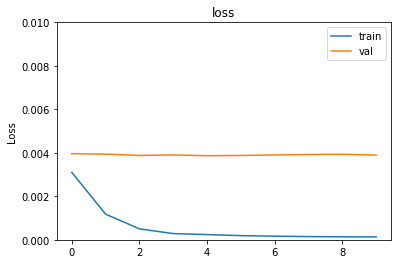

In [ ]:
plot_stats(simple_model_history, save_path='./plots/simple_model_training/loss.jpg', ymax=0.01)

# Evaluation

## Predicted

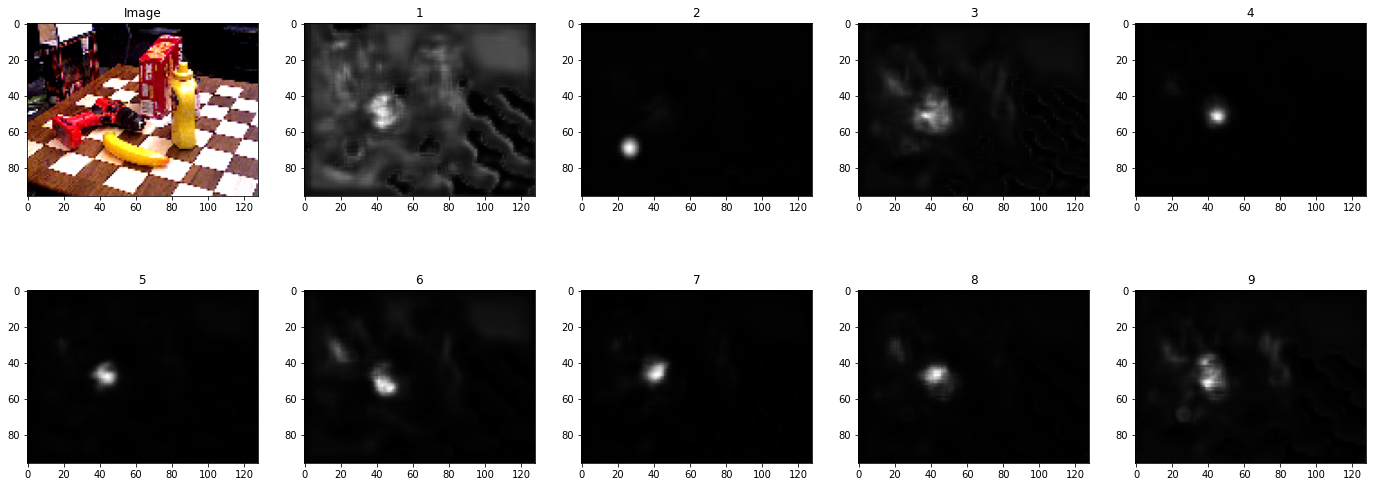

In [15]:
idx = 100

image = images_test[idx]
pred_heatmaps = stacked_hourglass_model.predict(np.array([image]))[-1][0]

plot_image_with_keypoints_heatmap(image, pred_heatmaps)

In [16]:
# plt.figure(figsize=(8, 5))

# plot_image_with_heatmaps(image, pred_heatmaps)

## Ground truth

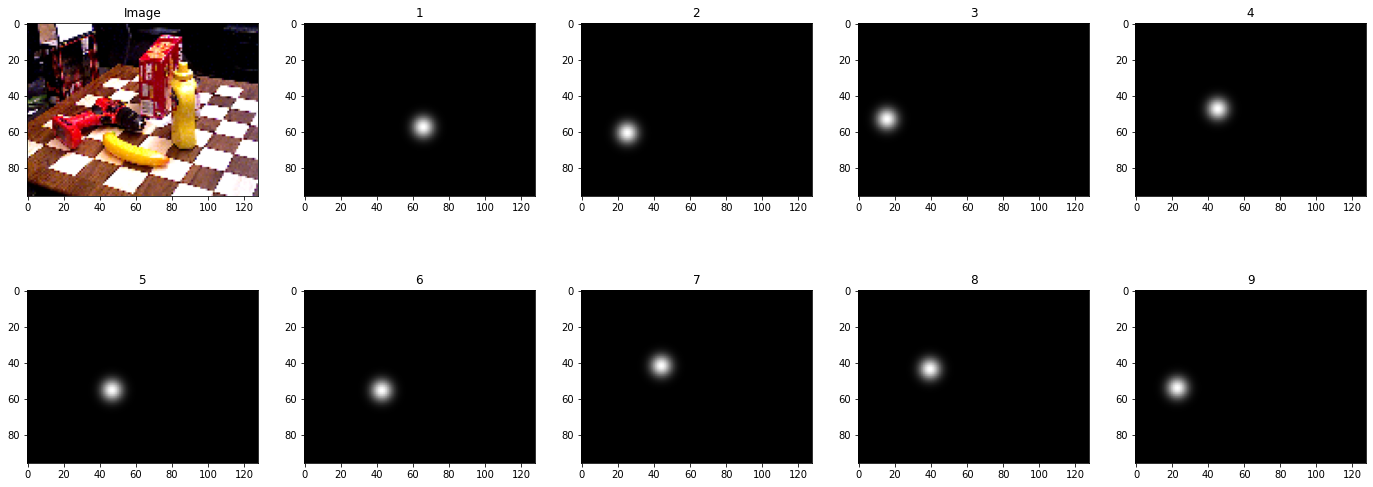

In [17]:
image = images_test[idx]
heatmaps = heatmaps_test[idx]

plot_image_with_keypoints_heatmap(image, heatmaps)

In [18]:
# plt.figure(figsize=(8, 5))

# plot_image_with_heatmaps(image, heatmaps)

# Retrieving keypoints from heatmaps

In [124]:
def load_keypoints(folder_numbers):
    return np.vstack([np.load(f'./keypoints/00{no}_gt_keypoints2d.npy') for no in folder_numbers]).reshape((-1, 2, N_KEYPOINTS))

true_keypoints_train = load_keypoints(['10', '11', '18', '24', '30', '37'])
true_keypoints_test = load_keypoints(['50'])
true_keypoints_train.shape, true_keypoints_test.shape

((1522, 2, 9), (320, 2, 9))

In [111]:
def retrieve_keypoints(heatmaps):
    tmp = heatmaps.reshape((heatmaps.shape[0], -1, N_KEYPOINTS))
    tmp = np.argmax(tmp, axis=1)
    tmp = tmp.reshape((tmp.shape[0], 1, tmp.shape[1]))
    return np.hstack([tmp % heatmaps.shape[2], tmp // heatmaps.shape[2]])

In [112]:
pred_keypoints_train = retrieve_keypoints(stacked_hourglass_model.predict(images_train)[-1]) * 5.
pred_keypoints_test = retrieve_keypoints(stacked_hourglass_model.predict(images_test)[-1]) * 5.

pred_keypoints_train.shape, pred_keypoints_test.shape

((1522, 2, 9), (320, 2, 9))

In [130]:
pred_keypoints_train[100]

array([[415., 350., 410., 390., 385., 385., 450., 440., 425.],
       [205., 320., 280., 185., 195., 220., 100., 125., 255.]])

In [131]:
true_keypoints_train[100]

array([[313., 201., 344., 325., 403., 280., 381., 174., 418.],
       [191., 385., 227., 448., 102., 445., 132., 430., 252.]])

In [127]:
def calculate_mse(true_values, pred_values):
    from sklearn.metrics import mean_squared_error
    return mean_squared_error(true_values, pred_values)

In [128]:
calculate_mse(true_keypoints_test.reshape(-1, 18), pred_keypoints_test.reshape((-1, 18))) / true_keypoints_test.shape[0]

26.240008680555555

In [129]:
calculate_mse(true_keypoints_train.reshape(-1, 18), pred_keypoints_train.reshape((-1, 18))) / true_keypoints_train.shape[0]

7.89034156937842